Import the necessary modules and stackoverflow csv files for 2019.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from collections import defaultdict
#import util_functions as uf
from util_functions import *
%matplotlib inline

df = pd.read_csv('./2019/survey_results_public.csv')
schema = pd.read_csv('./2019/survey_results_schema.csv')

Give a quick view of the survey results:

In [2]:
df.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


Give a quick view of the survey schema:

In [3]:
schema.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,MainBranch,Which of the following options best describes ...
2,Hobbyist,Do you code as a hobby?
3,OpenSourcer,How often do you contribute to open source?
4,OpenSource,How do you feel about the quality of open sour...


Lets take a look at the stats for this data set to get a feel for what we are looking at:

In [4]:
num_rows = df.shape[0] #Nnumber of rows in the dataset
num_cols = df.shape[1] #Number of columns in the dataset
num_rows, num_cols

(88883, 85)

Lets see if we have any columns that do NOT have missing data (NaN values).  This will be a much smaller list compared to showing the rows that have missing values:

In [5]:
no_nulls = set(df.columns[df.isnull().mean()==0]) #Set of columns with 0 missing values.
no_nulls

{'Hobbyist', 'OpenSourcer', 'Respondent'}

In [6]:
most_missing_cols = df.columns[df.isnull().mean() > 0.25] #Set of columns with more than 25% of the values missing
most_missing_cols

Index(['MgrIdiot', 'MgrMoney', 'MgrWant', 'CompTotal', 'CompFreq',
       'ConvertedComp', 'WorkWeekHrs', 'CodeRevHrs', 'UnitTests',
       'PurchaseHow', 'PurchaseWhat', 'WebFrameWorkedWith',
       'WebFrameDesireNextYear', 'MiscTechWorkedWith',
       'MiscTechDesireNextYear', 'BlockchainOrg', 'BlockchainIs'],
      dtype='object')

In [7]:
get_description('DevType', schema)

'Which of the following describe you? Please select all that apply.'

Lets focus on the rows for DevTypes that consider their job or part of their job a "Data scientist or machine learning specialist".  This will leave us with 6460 rows to work with. We will also remove the null values prior to this.

In [8]:
df = df[df.DevType.notnull()]
df = df[df['DevType'].str.contains('Data scientist or machine learning specialist')]
df.shape

(6460, 85)

We want to see what the education levels are for those in the Data Science/ML field(s):

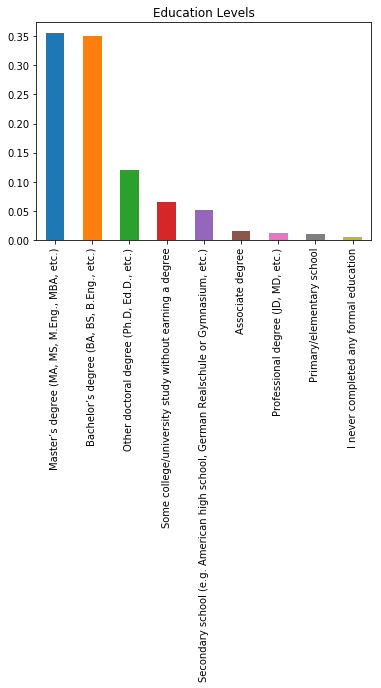

In [9]:
ed_vals = df.EdLevel.value_counts() #A pandas series of the counts for each EdLevel status

(ed_vals/df.shape[0]).plot(kind="bar");
plt.title("Education Levels");

Lets also have a look to see what the majors were for those in the Data Science/ML field(s):

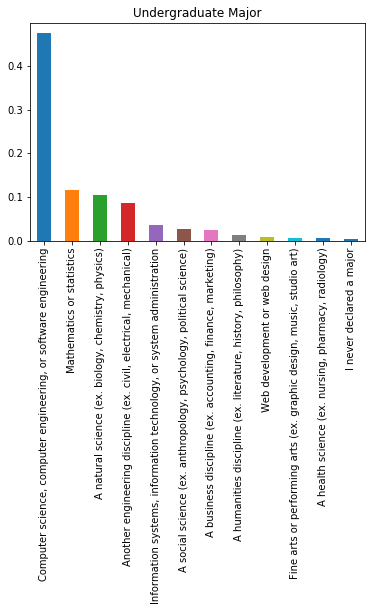

In [10]:
ed_vals = df.UndergradMajor.value_counts() #A pandas series of the counts for each UndergradMajor status

(ed_vals/df.shape[0]).plot(kind="bar");
plt.title("Undergraduate Major");

Out of curiosity, lets take a look at the average compensation (converted to USD) and average hours worked per week:

In [11]:
comp = df.ConvertedComp.mean()
hours = df.WorkWeekHrs.mean()

print("Compensation: ${:,.2f}\nHours: {}".format(comp, round(hours,1)))

Compensation: $142,191.27
Hours: 42.5


Lets take a look at the amount of time people in the DS/ML fields spend remotely working:

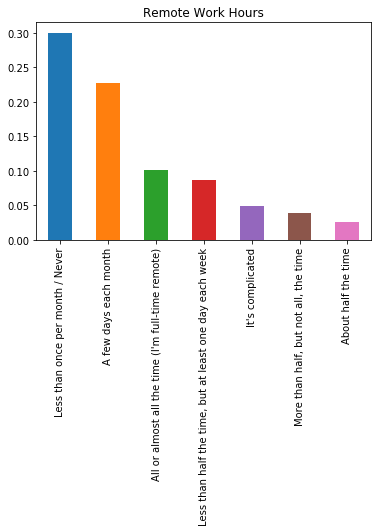

In [12]:
ed_vals = df.WorkRemote.value_counts() #A pandas series of the counts for each WorkRemote status

(ed_vals/df.shape[0]).plot(kind="bar");
plt.title("Remote Work Hours");

We are curious about the location people work to see if it lines up with the reported hours worked remotely.  

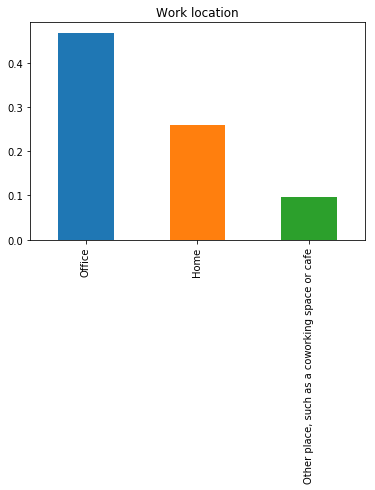

In [13]:
ed_vals = df.WorkLoc.value_counts() #A pandas series of the counts for each WorkLoc status

(ed_vals/df.shape[0]).plot(kind="bar");
plt.title("Work location");

In [14]:
#pd.DataFrame(df.query("LanguageWorkedWith == 'Professional developer' and (Gender == 'Male' or Gender == 'Female')").groupby(['Gender', 'FormalEducation']).mean()['Salary'])

In [15]:
lang_vals = df.LanguageWorkedWith.value_counts()[:19]  #Provide a pandas series of the counts for each FormalEducation status
lang_vals

#(lang_vals/df.shape[0]).plot(kind="bar");
#plt.title("Formal Education");

Python                                                    173
Python;R;SQL                                              109
Python;SQL                                                 84
Python;R                                                   81
Bash/Shell/PowerShell;Python;R;SQL                         72
Bash/Shell/PowerShell;Python                               69
R                                                          61
Bash/Shell/PowerShell;Python;SQL                           54
Bash/Shell/PowerShell;HTML/CSS;JavaScript;Python;SQL       49
C++;Python                                                 43
HTML/CSS;JavaScript;Python;SQL                             41
R;SQL                                                      39
HTML/CSS;JavaScript;Python                                 38
Bash/Shell/PowerShell;C++;Python                           32
Java;Python                                                32
Bash/Shell/PowerShell;HTML/CSS;JavaScript;Python;R;SQL     31
Bash/She

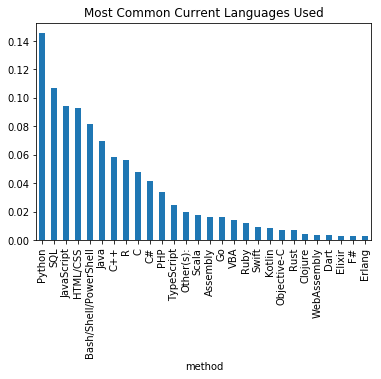

In [16]:
#lang_vals = ["PHP","Python","R","SQL","Java","Bash/Shell/PowerShell","HTML/CSS","JavaScript","C","C++", "C#","Swift", "Go", "Scala", "Rust", "Ruby", "Other(s)"]
lang_vals = count_lists(df, col='LanguageWorkedWith', delim=';')
props_df = clean_and_plot(df, lang_vals, col='LanguageWorkedWith', title='Most Common Current Languages Used')

In [18]:
lang_vals = df.LanguageDesireNextYear.value_counts()[:19]  #Provide a pandas series of the counts for each FormalEducation status
lang_vals

#(lang_vals/df.shape[0]).plot(kind="bar");
#plt.title("Formal Education");

Python                                                  226
Python;R;SQL                                             98
Python;R                                                 89
Python;SQL                                               88
C++;Python                                               64
Bash/Shell/PowerShell;Python                             45
R                                                        43
Bash/Shell/PowerShell;Python;R;SQL                       41
JavaScript;Python                                        37
HTML/CSS;JavaScript;Python                               37
Other(s):                                                36
Java;Python                                              32
Bash/Shell/PowerShell;Python;SQL                         31
Python;Other(s):                                         30
Go;Python                                                29
Python;Scala                                             28
Python;Rust                             

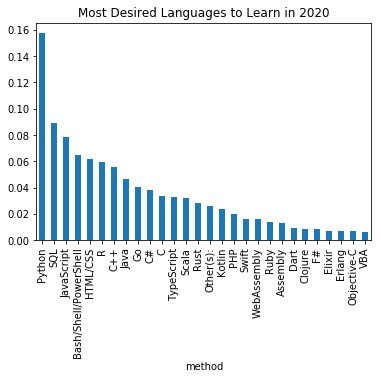

In [22]:
lang_vals = count_lists(df, col='LanguageDesireNextYear', delim=';')
props_df = clean_and_plot(df, lang_vals, col='LanguageDesireNextYear', title='Most Desired Languages to Learn in 2020')

In [ ]:
#other_ed_vals = df.EduOther.value_counts()#Provide a pandas series of the counts for each CousinEducation status

#other_ed_vals # assure this looks right

In [20]:
lang_vals = df.DatabaseWorkedWith.value_counts()[:19]  #Provide a pandas series of the counts for each FormalEducation status
lang_vals

#(lang_vals/df.shape[0]).plot(kind="bar");
#plt.title("Formal Education");

MySQL                                265
Microsoft SQL Server                 247
PostgreSQL                           234
SQLite                               143
PostgreSQL;SQLite                    124
MySQL;SQLite                         119
Microsoft SQL Server;MySQL           109
MongoDB                               99
Other(s):                             93
MySQL;PostgreSQL;SQLite               88
MySQL;PostgreSQL                      69
Oracle                                60
Microsoft SQL Server;MySQL;SQLite     54
Microsoft SQL Server;SQLite           53
MySQL;Oracle                          52
Microsoft SQL Server;Oracle           50
MongoDB;MySQL                         47
Microsoft SQL Server;PostgreSQL       47
MongoDB;PostgreSQL                    45
Name: DatabaseWorkedWith, dtype: int64

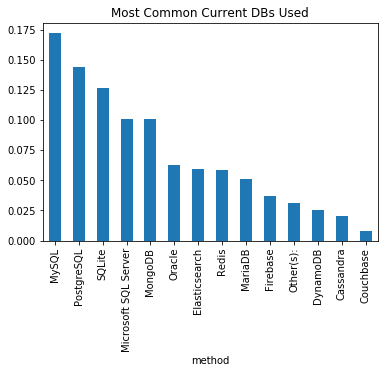

In [21]:
lang_vals = count_lists(df, col='DatabaseWorkedWith', delim=';')
props_df = clean_and_plot(df, lang_vals, col='DatabaseWorkedWith', title='Most Common Current DBs Used')

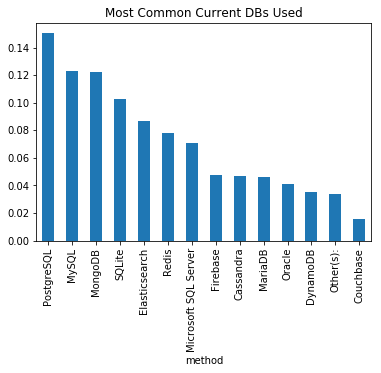

In [24]:
lang_vals = count_lists(df, col='DatabaseDesireNextYear', delim=';')
props_df = clean_and_plot(df, lang_vals, col='DatabaseDesireNextYear', title='Most Common Current DBs Used')